In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from src import camvid
from src import tiramisu
from src.callbacks import PlotMetrics
from src.utils import history_to_results
%matplotlib inline
plt.style.use('dark_background')

Using TensorFlow backend.
/usr/local/anaconda5/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
!mkdir -p models
# the location to save coarse training weights to
coarse_weights = './models/Tiramisu103-CamVid11-coarse2.h5'
# the location to save fine training weights to
fine_weights = './models/Tiramisu103-CamVid11-fine2.h5'

In [3]:
mapping = pd.read_table('11_class.txt', sep=r'\s+', names=['og', 'new'], index_col='og')['new'].to_dict()
mapping

{'Animal': 'Pedestrian',
 'Archway': 'Void',
 'Bicyclist': 'Bicyclist',
 'Bridge': 'Void',
 'Building': 'Building',
 'Car': 'Car',
 'CartLuggagePram': 'Void',
 'Child': 'Pedestrian',
 'Column_Pole': 'Column_Pole',
 'Fence': 'Fence',
 'LaneMkgsDriv': 'Road',
 'LaneMkgsNonDriv': 'Road',
 'Misc_Text': 'SignSymbol',
 'MotorcycleScooter': 'Car',
 'OtherMoving': 'Car',
 'ParkingBlock': 'Sidewalk',
 'Pedestrian': 'Pedestrian',
 'Road': 'Road',
 'RoadShoulder': 'Road',
 'SUVPickupTruck': 'Car',
 'Sidewalk': 'Sidewalk',
 'SignSymbol': 'SignSymbol',
 'Sky': 'Sky',
 'TrafficCone': 'Void',
 'TrafficLight': 'Void',
 'Train': 'Car',
 'Tree': 'VegetationMisc',
 'Truck_Bus': 'Car',
 'Tunnel': 'Void',
 'VegetationMisc': 'VegetationMisc',
 'Void': 'Void',
 'Wall': 'Building'}

In [4]:
# the size to reshape images to before transformation
target_size = (360, 480)
# the size to crop images to for coarse training
coarse_crop = (224, 224)
# the batch size during coarse training
coarse_batch = 3
# the size to crop images to for fine tune training
fine_crop = (352, 480)
# the batch size during fine training
fine_batch = 1

In [5]:
# all crop dimensions must be divisible by this value due 
# to the requirement of equal shapes between downsampling 
# outputs and upsampling inputs imposed by the concatenation
# in skip link connections
divisible_by = int(2**5)
# iterate over all the crop dimensions
for dim in coarse_crop + fine_crop:
    # raise error if the dimension has a remainder when divided
    if dim % divisible_by:
        f = 'crop dimension ({}) must be divisible by {}'
        f = f.format(dim, divisible_by)
        raise ValueError(f)

# Coarse Tuning

In [6]:
camvid11 = camvid.CamVid(
    mapping=mapping,
    target_size=target_size,
    crop_size=coarse_crop,
    batch_size=coarse_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


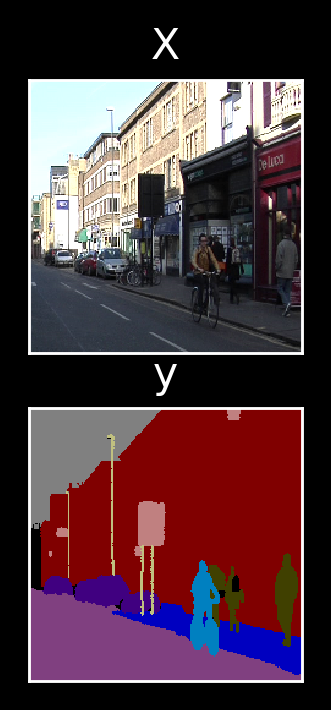

In [7]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [8]:
# build the model for the image shape and number of labels
model = tiramisu.build_tiramisu((*coarse_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=(camvid11.class_weights > 0).astype(int),
    contrast_norm=None,
    learning_rate=1e-3,
)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 224, 224, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [9]:
callbacks = [
    EarlyStopping(monitor='val_acc', patience=100),
    LearningRateScheduler(lambda _, lr: 0.995 * lr),
    ModelCheckpoint(coarse_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

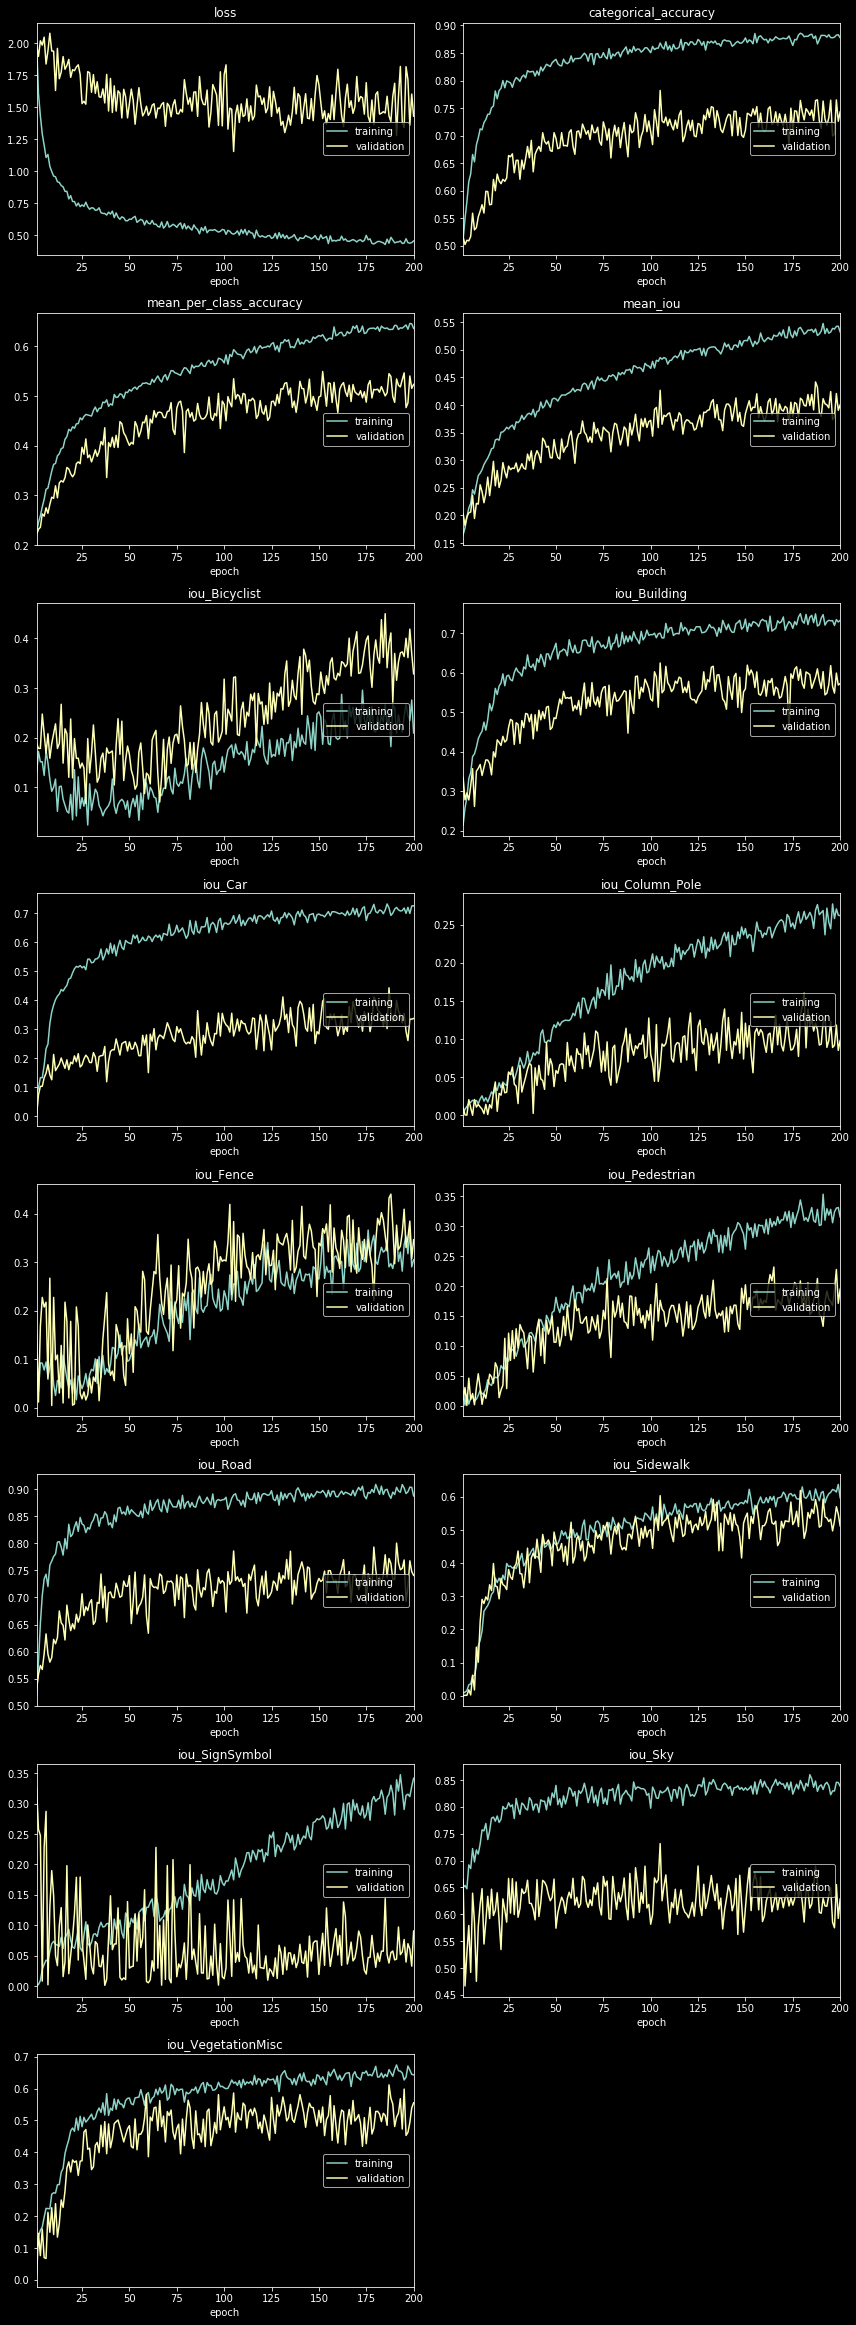

In [10]:
# fit the model with the data. divide the steps per epoch by the batch size
history = model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / coarse_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0
)

In [11]:
history_to_results(history)

train       val
categorical_accuracy     0.877735  0.742990
Bicyclist                0.209388  0.328530
Building                 0.732176  0.572357
Car                      0.725756  0.337024
Column_Pole              0.262104  0.098121
Fence                    0.305259  0.346609
Pedestrian               0.315450  0.194629
Road                     0.887471  0.740779
Sidewalk                 0.597271  0.512493
SignSymbol               0.341493  0.090652
Sky                      0.838677  0.628385
VegetationMisc           0.643244  0.555347
loss                     0.456046  1.430608
mean_iou                 0.532572  0.400448
mean_per_class_accuracy  0.636245  0.523415

## Test Metrics

In [12]:
model.load_weights(coarse_weights)

In [13]:
metrics = model.evaluate_generator(generators['test'], steps=233)
names = model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     0.651432
categorical_accuracy     0.822150
mean_per_class_accuracy  0.510861
mean_iou                 0.406297
iou_Bicyclist            0.285233
iou_Building             0.617440
iou_Car                  0.400533
iou_Column_Pole          0.138707
iou_Fence                0.076485
iou_Pedestrian           0.214653
iou_Road                 0.764077
iou_Sidewalk             0.535278
iou_SignSymbol           0.116388
iou_Sky                  0.837835
iou_VegetationMisc       0.482638

## Qualitative Results

In [14]:
def predict(generator):
    X, y = next(generator)
    p = model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

In [15]:
X, y, p = predict(generators['train'])

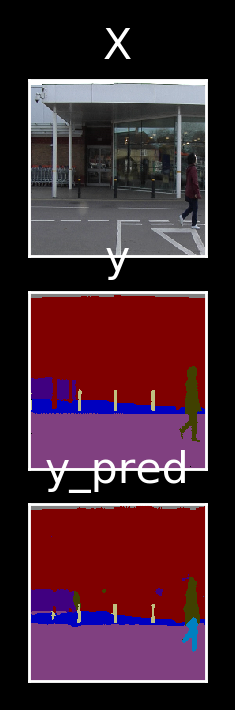

In [16]:
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

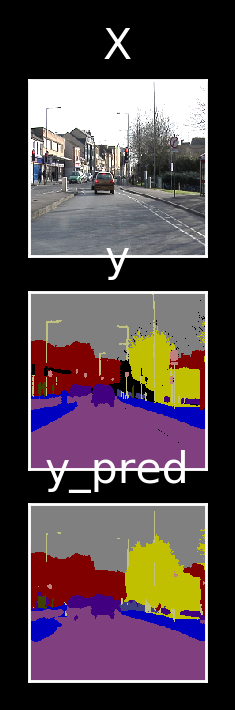

In [17]:
camvid.plot(X=X[1], y=y[1], y_pred=p[1], order=['X', 'y', 'y_pred'])

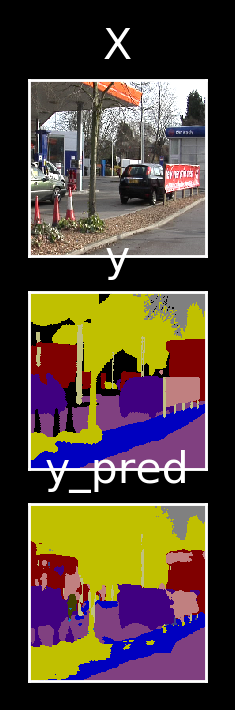

In [18]:
camvid.plot(X=X[2], y=y[2], y_pred=p[2], order=['X', 'y', 'y_pred'])

### Validation

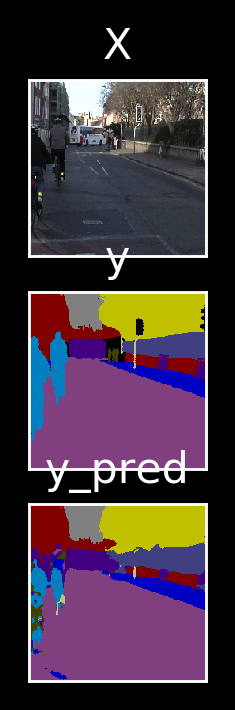

In [19]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

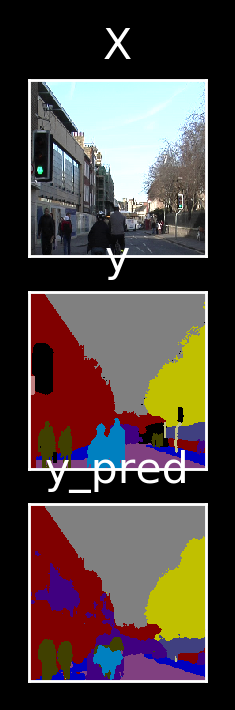

In [20]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

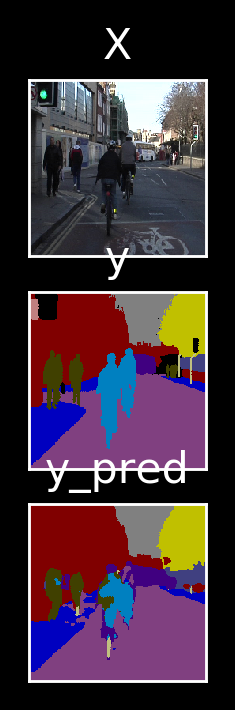

In [21]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

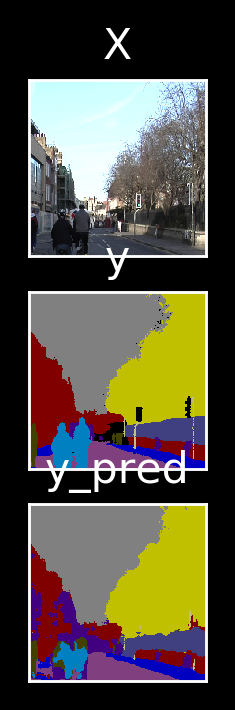

In [22]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

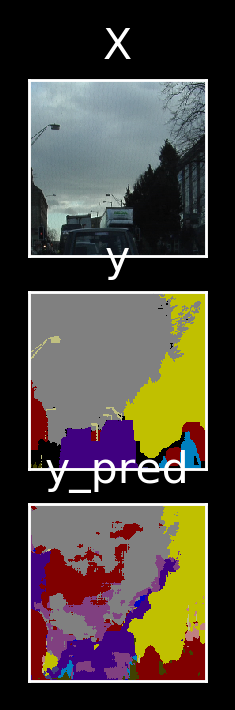

In [23]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

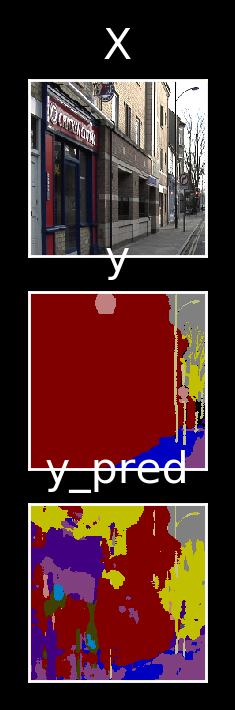

In [24]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

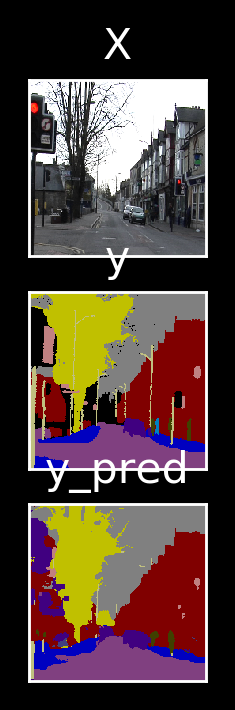

In [25]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

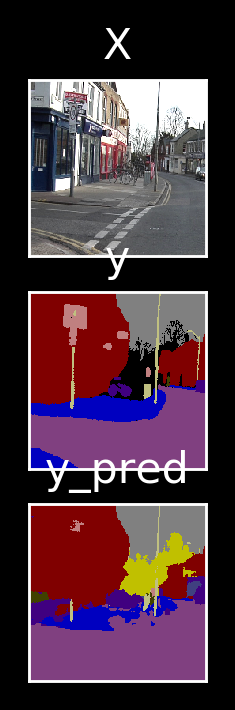

In [26]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

# Clear Session

remove the current model from memory.

In [27]:
from keras import backend as K
K.clear_session()

# Fine Tuning

In [28]:
camvid11 = camvid.CamVid(
    mapping=mapping,
    target_size=target_size,
    crop_size=fine_crop,
    batch_size=fine_batch,
    horizontal_flip=True,
    ignored_labels=['Void'],
)
generators = camvid11.generators()

Found 367 images belonging to 1 classes.
Found 367 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 101 images belonging to 1 classes.
Found 233 images belonging to 1 classes.
Found 233 images belonging to 1 classes.


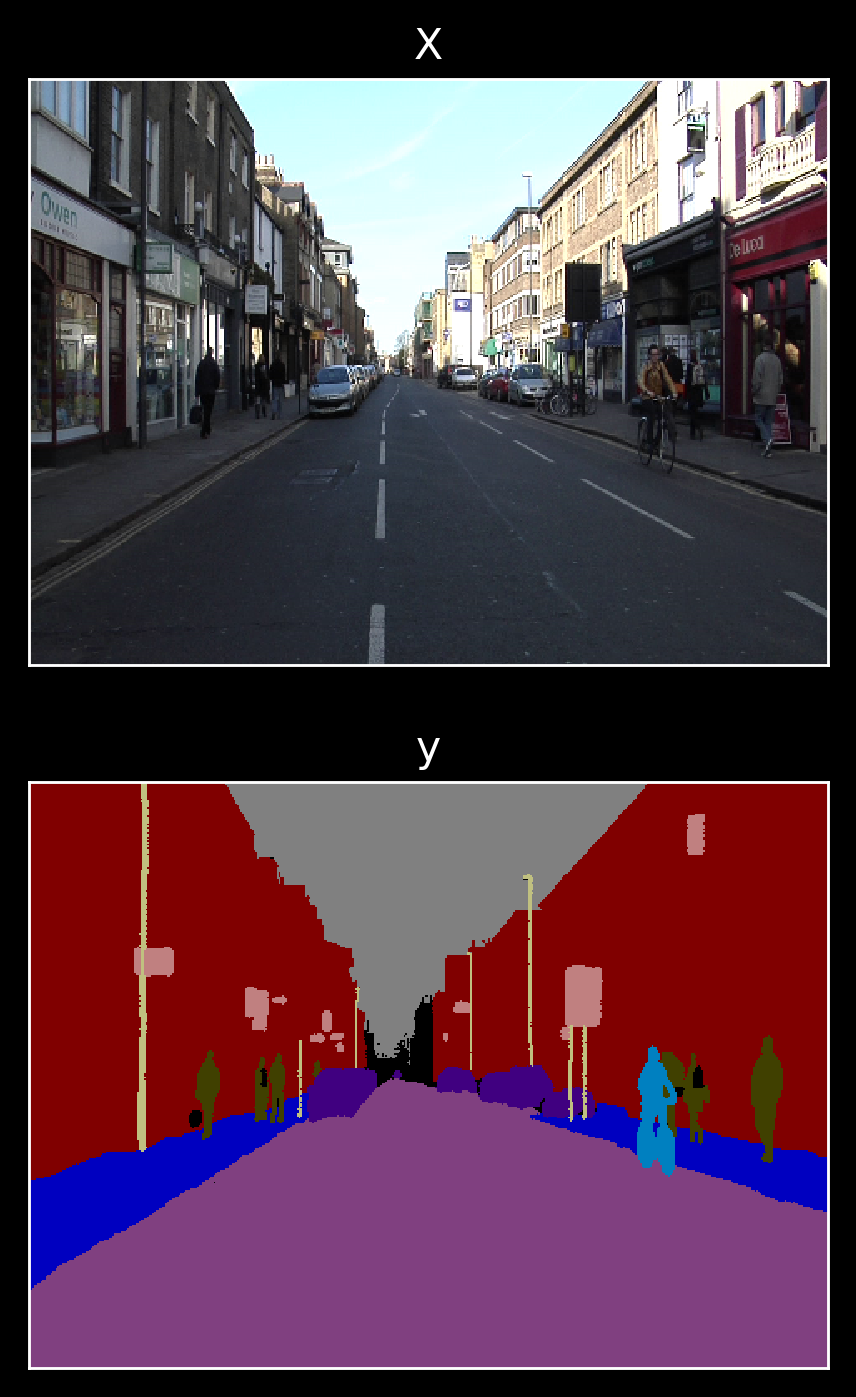

In [29]:
# get the next X, y training tuple
X, y = next(generators['train'])
# transform the onehot vector to an image
y = camvid11.unmap(y)
# plot the images
camvid.plot(X=X[0], y=y[0], order=['X', 'y'])

In [30]:
# build the model for the image shape and number of labels
tune_model = tiramisu.build_tiramisu((*fine_crop, 3), camvid11.n,
    label_names=camvid11.discrete_to_label_map,
    class_weights=(camvid11.class_weights > 0).astype(int),
    contrast_norm=None,
    learning_rate=1e-4,
)
# load the weights from the coarsely trained model
tune_model.load_weights(coarse_weights)
tune_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tiramisu_input (InputLayer)     (None, 352, 480, 3)  0                                            
__________________________________________________________________________________________________
pixel_norm (Lambda)             (None, 352, 480, 3)  0           Tiramisu_input[0][0]             
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 352, 480, 48) 1344        pixel_norm[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 352, 480, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [31]:
callbacks = [
    EarlyStopping(monitor='val_acc', patience=50),
    ModelCheckpoint(fine_weights, 
        monitor='val_categorical_accuracy', 
        save_best_only=True, 
        save_weights_only=True, 
        mode='max'
    ),
    PlotMetrics(),
]

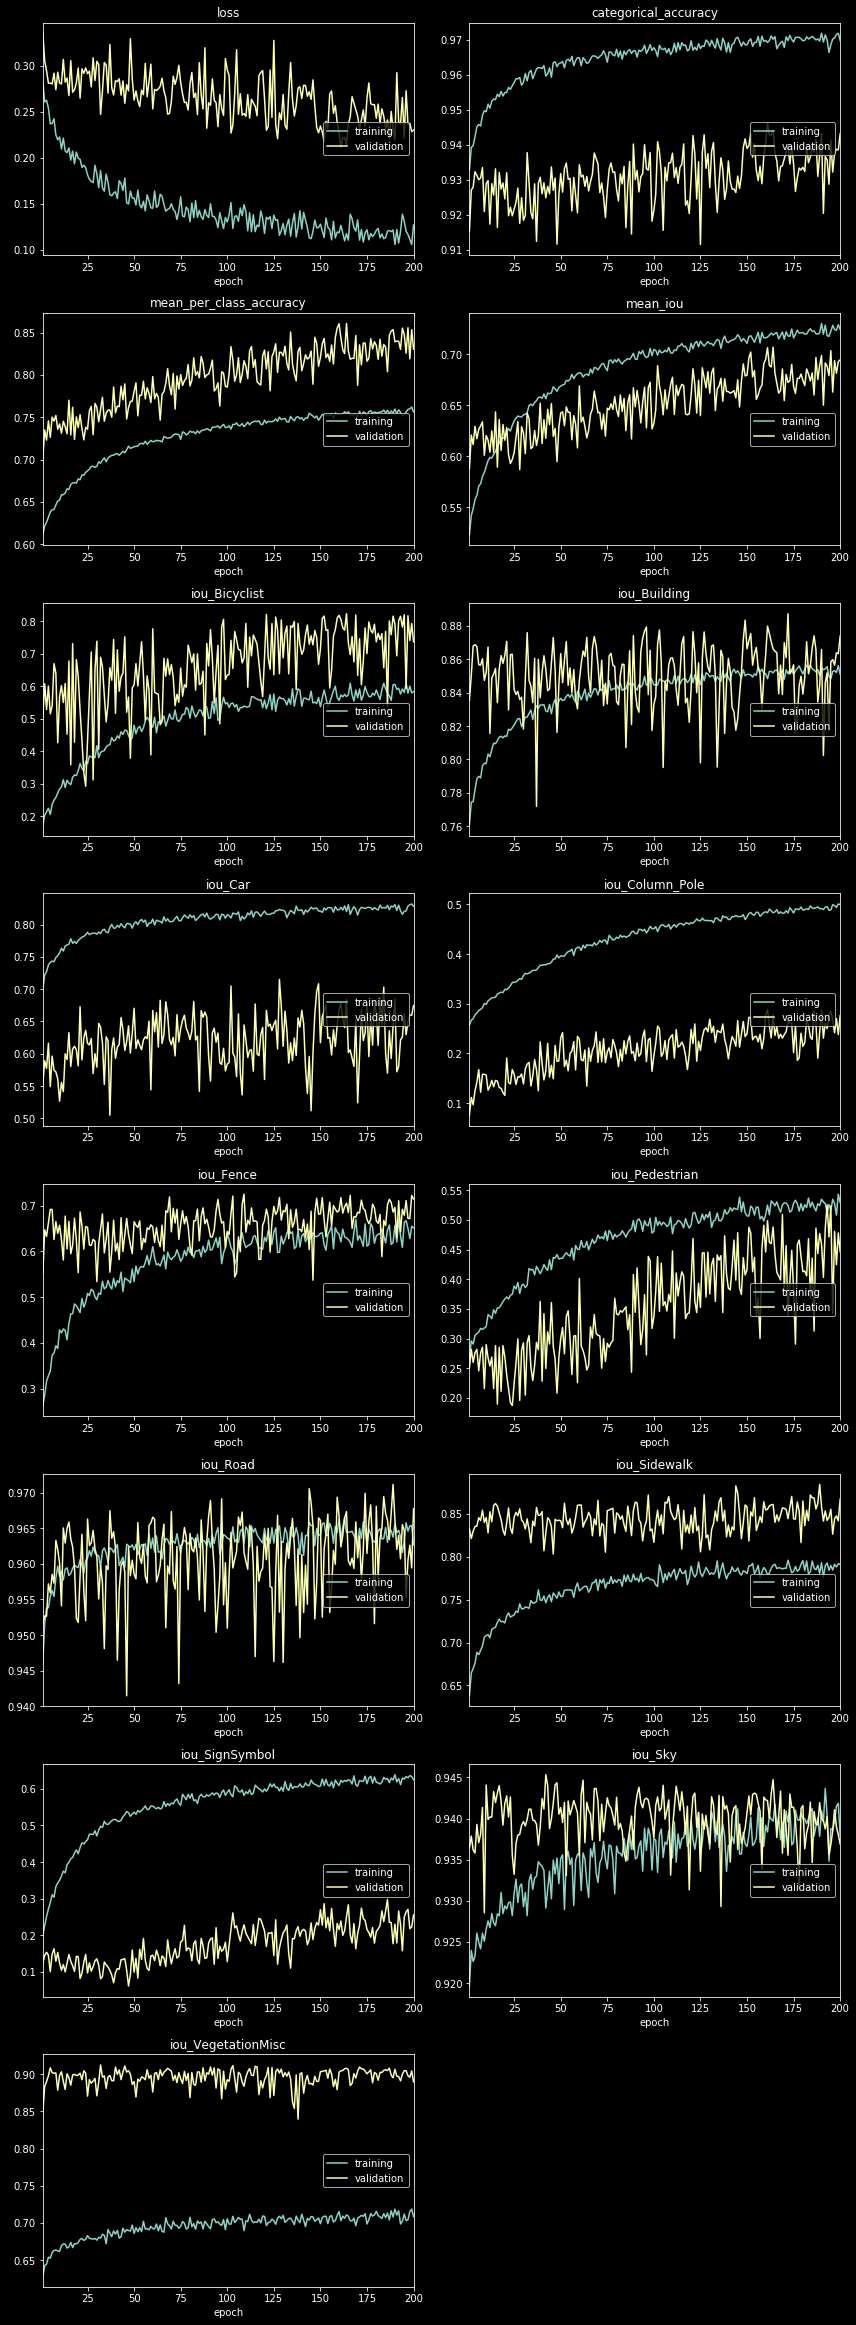

In [32]:
# fit the model with the data.
history = tune_model.fit_generator(generators['train'],
    epochs=200,
    steps_per_epoch=int(367 / fine_batch),
    validation_data=generators['val'],
    validation_steps=101,
    callbacks=callbacks,
    verbose=0,
)

In [33]:
history_to_results(history)

train       val
categorical_accuracy     0.969815  0.943128
Bicyclist                0.582827  0.736649
Building                 0.851005  0.873875
Car                      0.828225  0.674554
Column_Pole              0.499447  0.276119
Fence                    0.651486  0.714446
Pedestrian               0.529161  0.446335
Road                     0.962665  0.967742
Sidewalk                 0.791166  0.867294
SignSymbol               0.624774  0.255040
Sky                      0.937957  0.936905
VegetationMisc           0.708331  0.889703
loss                     0.126726  0.230100
mean_iou                 0.724277  0.694424
mean_per_class_accuracy  0.756300  0.830315

## Test Metrics

In [34]:
tune_model.load_weights(fine_weights)

In [35]:
metrics = tune_model.evaluate_generator(generators['test'], steps=233)
names = tune_model.metrics_names
pd.DataFrame(metrics, names, columns=['test'])

test
loss                     0.444045
categorical_accuracy     0.893243
mean_per_class_accuracy  0.645533
mean_iou                 0.499167
iou_Bicyclist            0.098403
iou_Building             0.709252
iou_Car                  0.548525
iou_Column_Pole          0.294447
iou_Fence                0.098811
iou_Pedestrian           0.342050
iou_Road                 0.900283
iou_Sidewalk             0.787167
iou_SignSymbol           0.209551
iou_Sky                  0.907727
iou_VegetationMisc       0.594623

## Qualitative Results

In [36]:
def predict(generator):
    X, y = next(generator)
    p = tune_model.predict(X)
    return X, camvid11.unmap(y), camvid11.unmap(p)

### Train

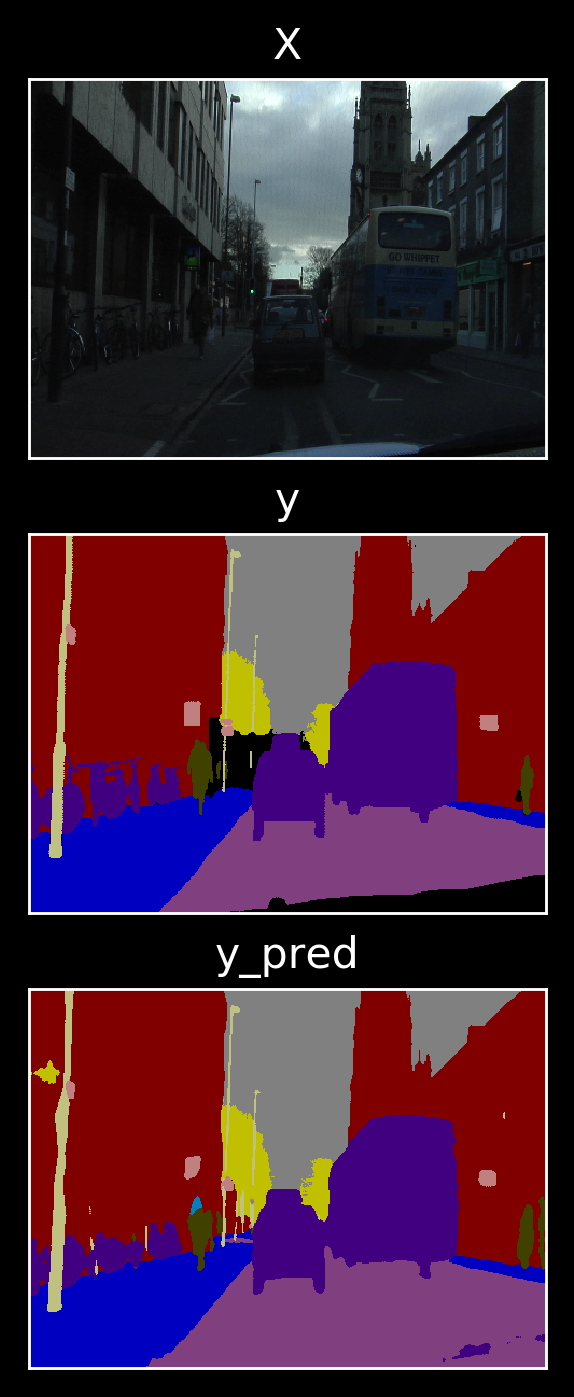

In [37]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

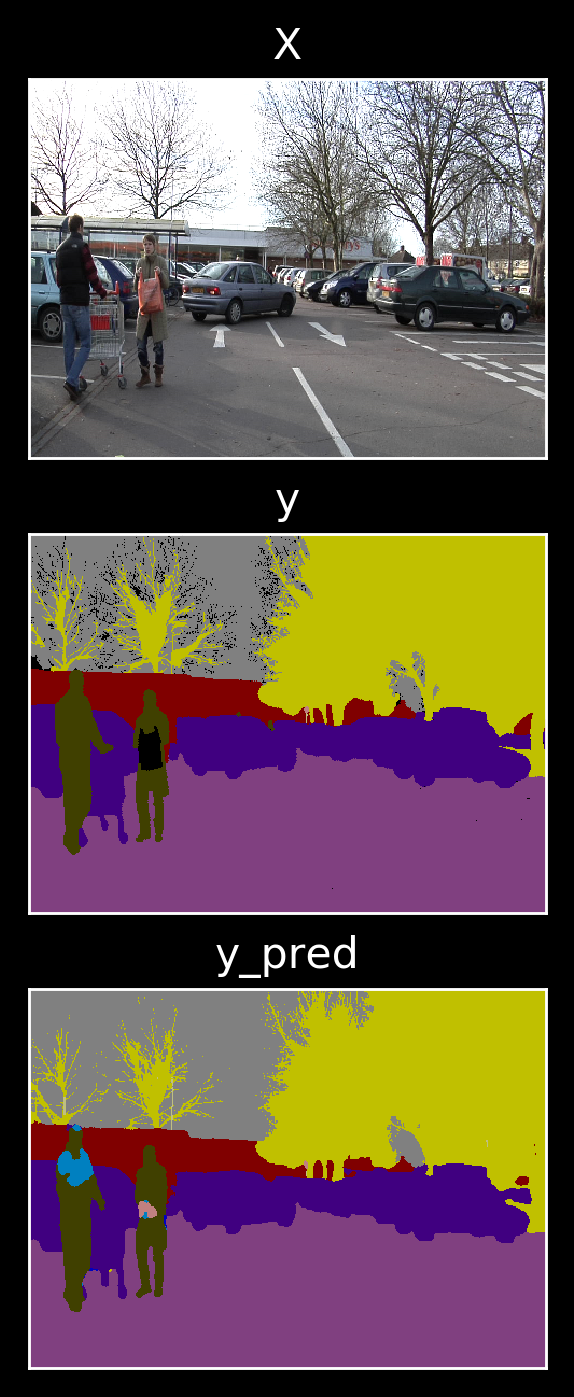

In [38]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

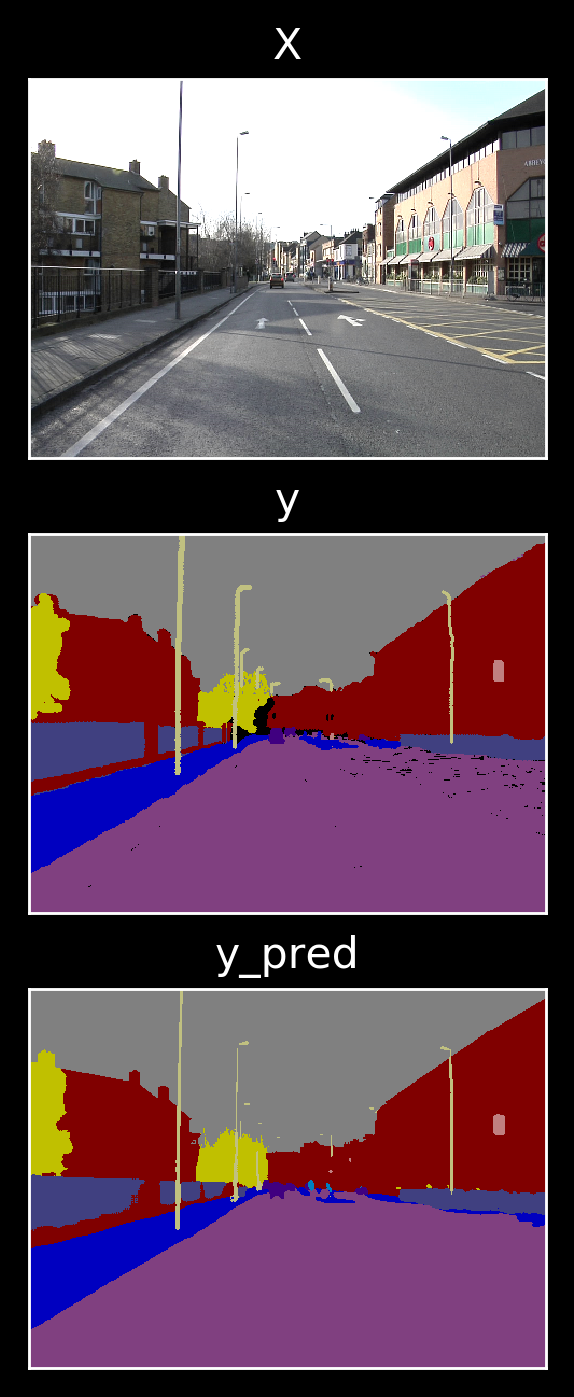

In [39]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

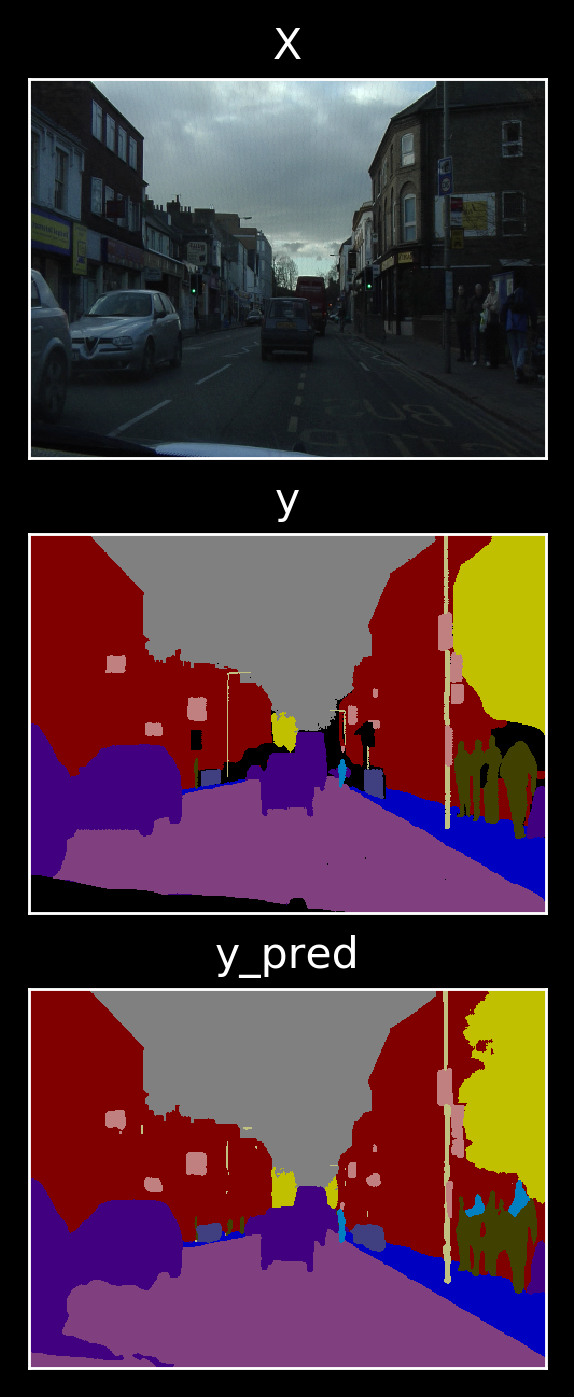

In [40]:
X, y, p = predict(generators['train'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Validation

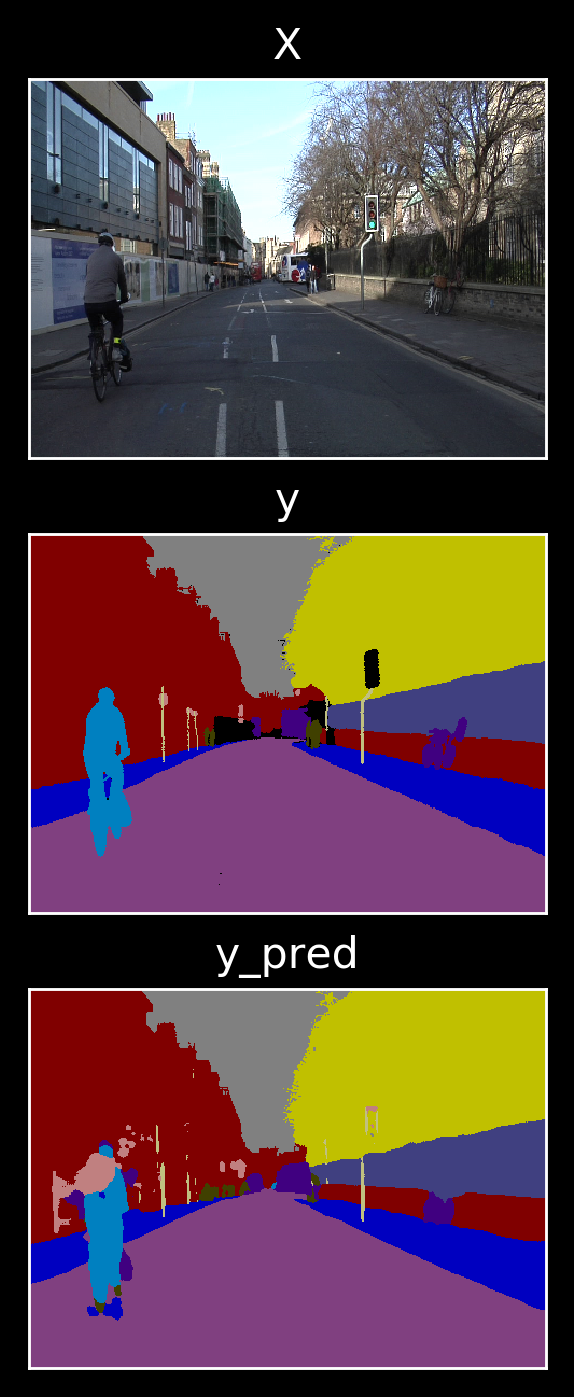

In [41]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

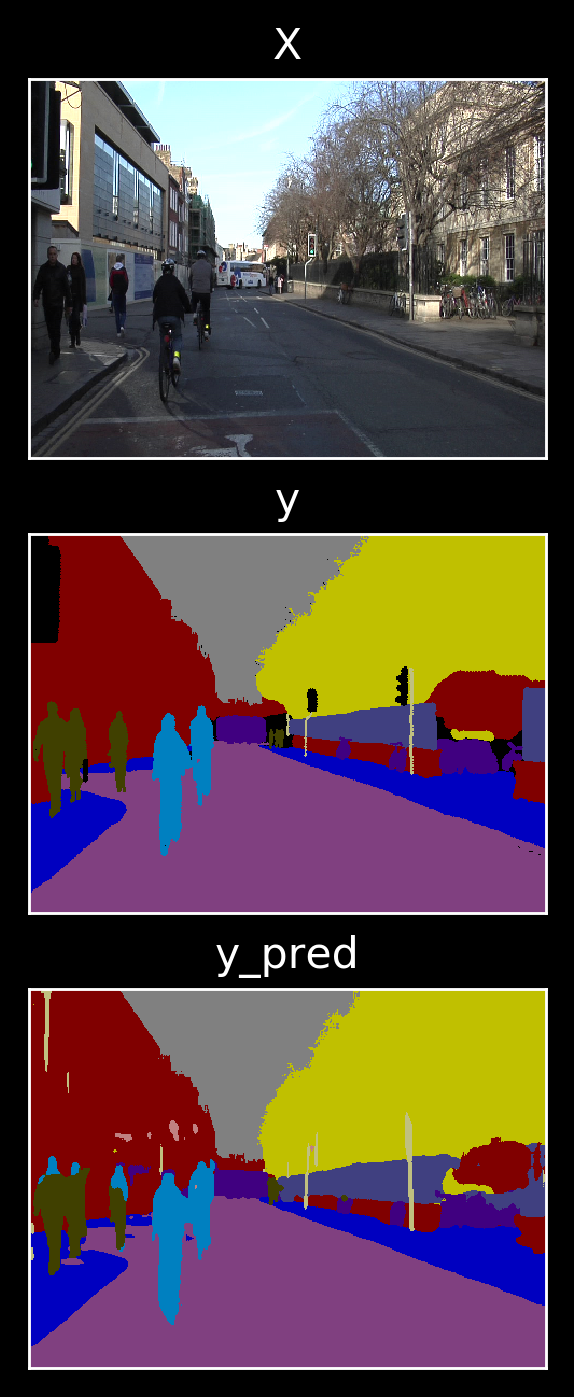

In [42]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

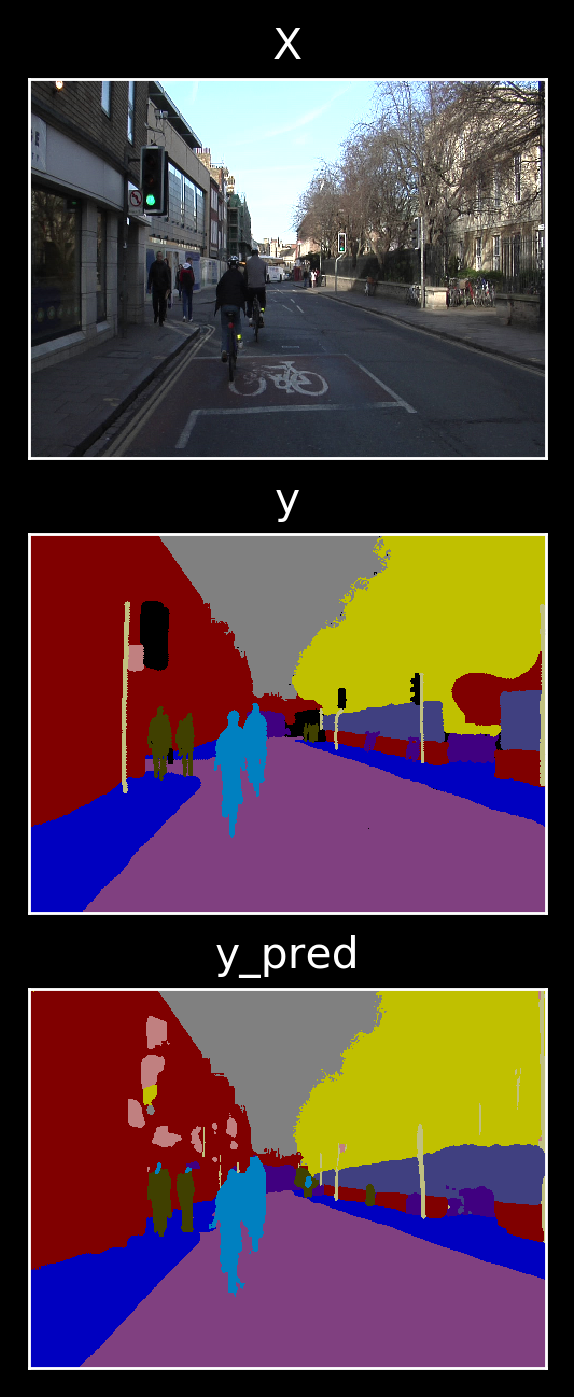

In [43]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

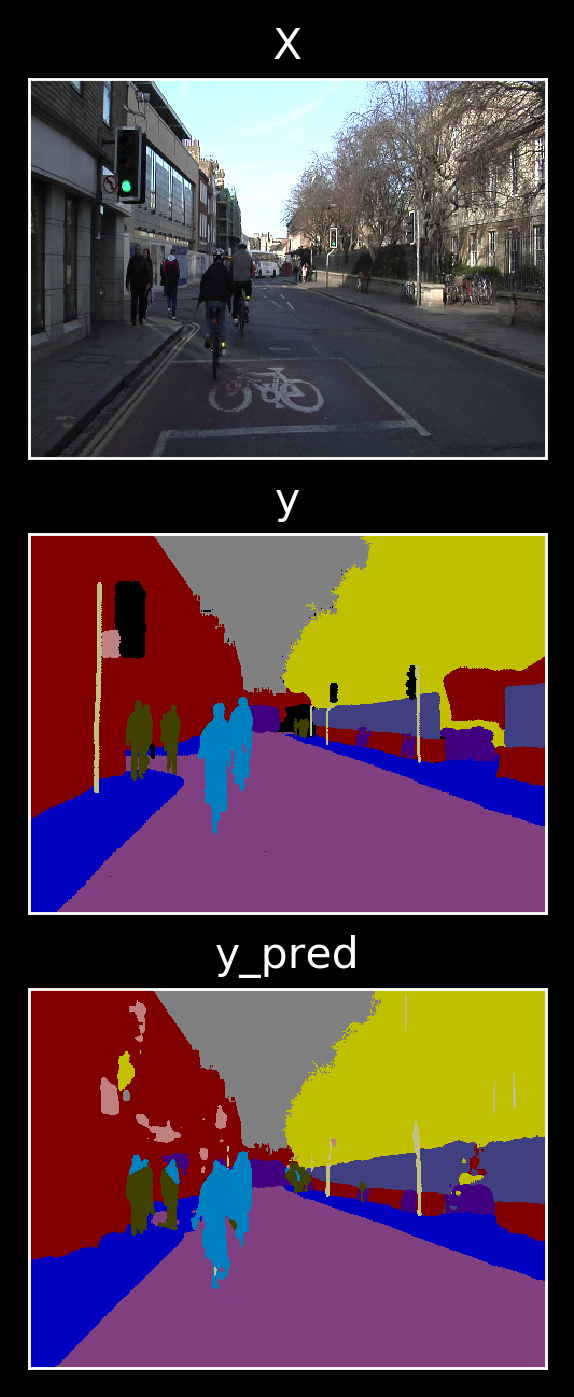

In [44]:
X, y, p = predict(generators['val'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

### Test

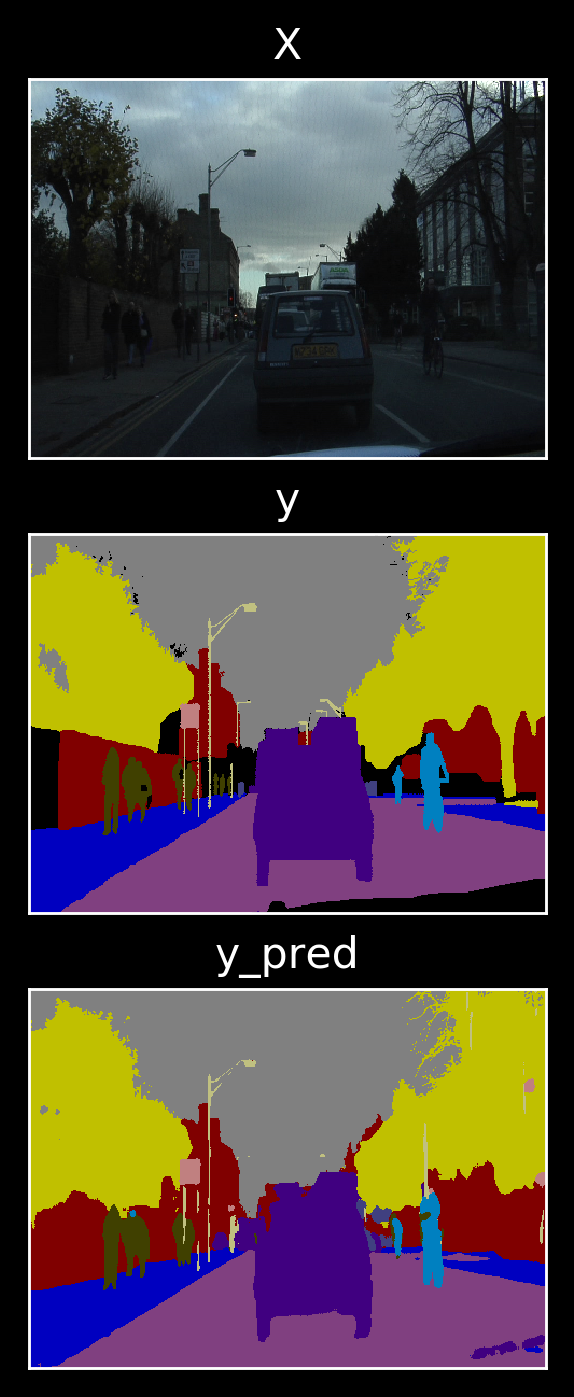

In [45]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

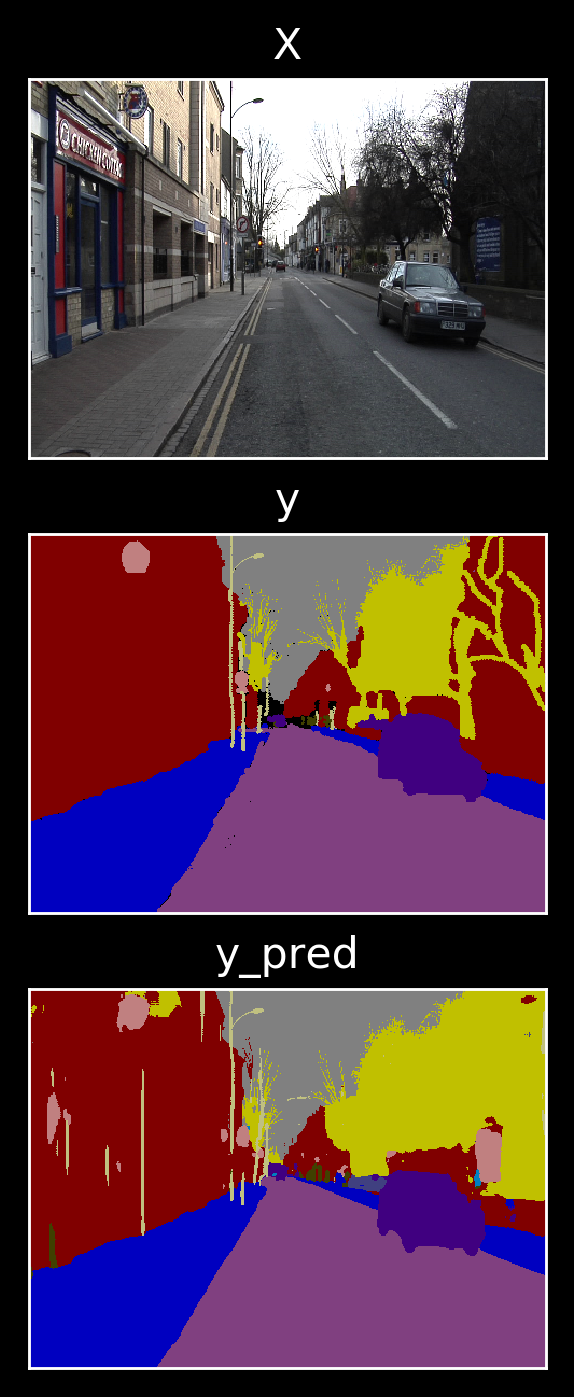

In [46]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

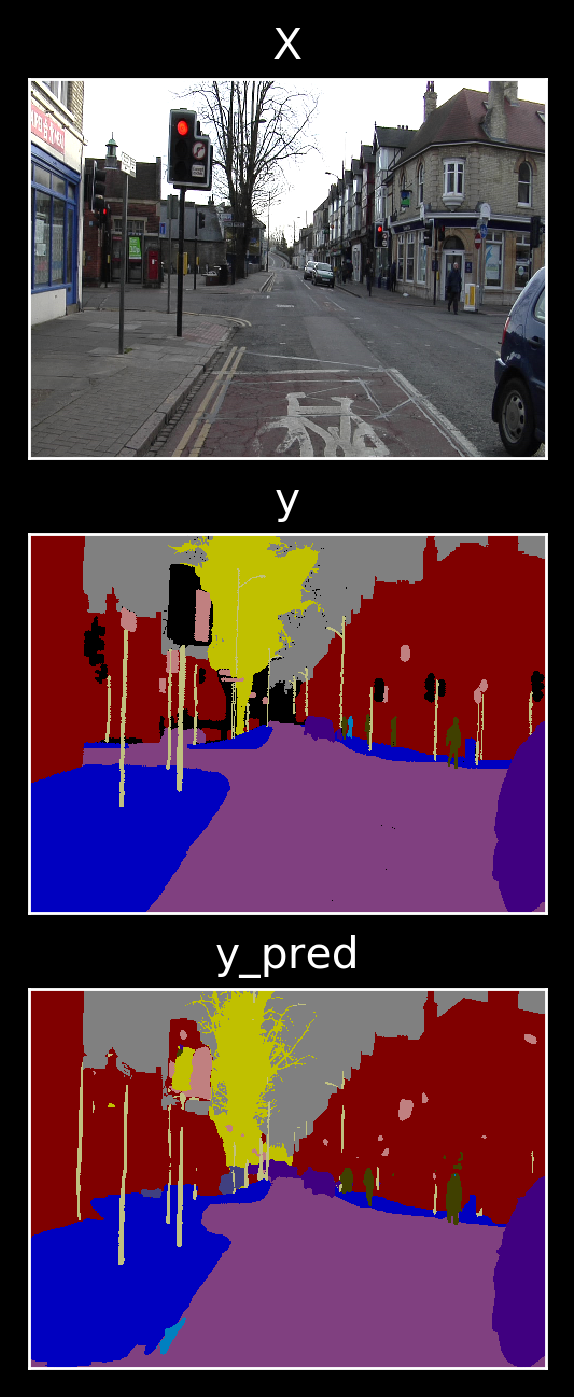

In [47]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])

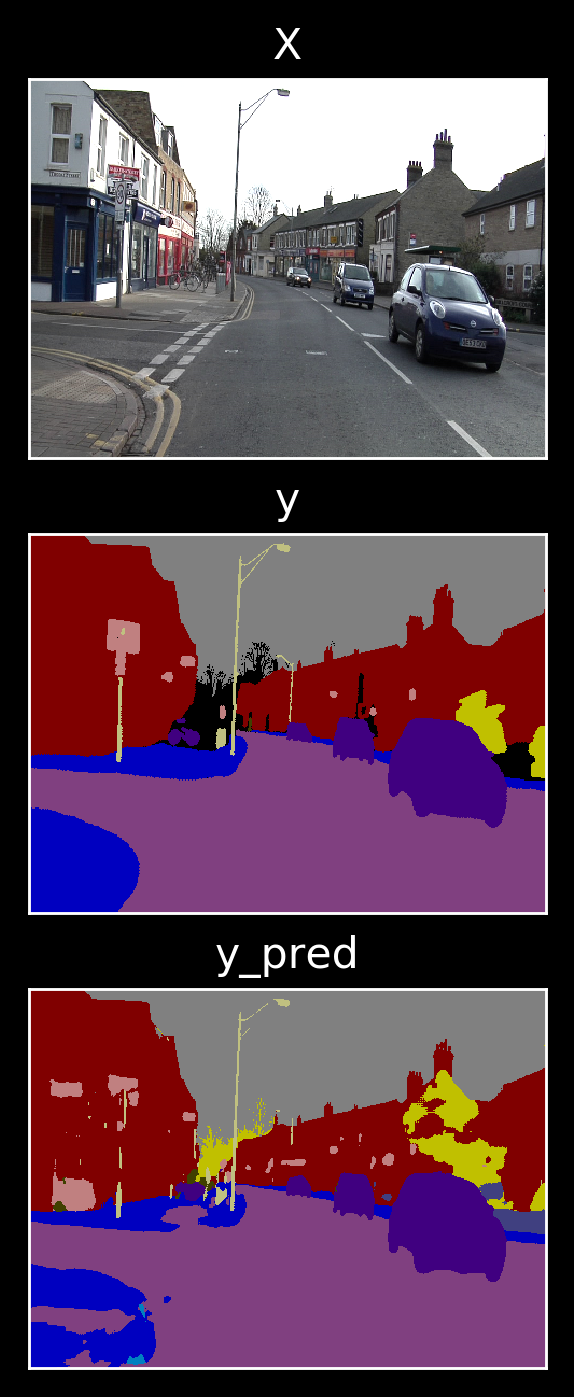

In [48]:
X, y, p = predict(generators['test'])
camvid.plot(X=X[0], y=y[0], y_pred=p[0], order=['X', 'y', 'y_pred'])